In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

2025-06-27 22:08:08.748446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751062089.059646      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751062089.167718      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== FER-2013 Facial Expression Recognition Analysis (with CNN) ===")
print("Classifiers: Random Forest, Decision Tree, KNN, Neural Network MLP, CNN")
print("Dataset: FER-2013 Image Folders (48x48 pixels)")
print("Classes: 7 emotions (angry, disgust, fear, happy, sad, surprise, neutral)")
print(f"TensorFlow version: {tf.__version__}")

=== FER-2013 Facial Expression Recognition Analysis (with CNN) ===
Classifiers: Random Forest, Decision Tree, KNN, Neural Network MLP, CNN
Dataset: FER-2013 Image Folders (48x48 pixels)
Classes: 7 emotions (angry, disgust, fear, happy, sad, surprise, neutral)
TensorFlow version: 2.18.0


## 1. DATA LOADING FROM IMAGE FOLDERS

In [4]:
def load_images_from_folder(base_path):
    """Load images from organized folder structure"""
    
    # Define emotion mapping based on your folder structure
    emotion_folders = {
        'angry': 0,
        'disgust': 1, 
        'fear': 2,
        'happy': 3,
        'sad': 4,
        'surprise': 5,
        'neutral': 6
    }
    
    emotion_labels = {
        0: 'Angry',
        1: 'Disgust', 
        2: 'Fear',
        3: 'Happy',
        4: 'Sad',
        5: 'Surprise',
        6: 'Neutral'
    }
    
    images = []
    labels = []
    file_paths = []
    
    # Check if using train/test structure
    if os.path.exists(os.path.join(base_path, 'train')):
        # Structure: base_path/train/emotion_folder/images
        data_splits = ['train', 'test']
        split_labels = []
        
        for split in data_splits:
            split_path = os.path.join(base_path, split)
            if os.path.exists(split_path):
                print(f"\nLoading {split} data...")
                
                for emotion_name, emotion_id in emotion_folders.items():
                    emotion_path = os.path.join(split_path, emotion_name)
                    
                    if os.path.exists(emotion_path):
                        image_files = [f for f in os.listdir(emotion_path) 
                                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                        print(f"  {emotion_name}: {len(image_files)} images")
                        
                        for image_file in image_files:
                            image_path = os.path.join(emotion_path, image_file)
                            try:
                                # Load image
                                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                                if img is not None:
                                    # Resize to 48x48 if needed
                                    if img.shape != (48, 48):
                                        img = cv2.resize(img, (48, 48))
                                    
                                    images.append(img)
                                    labels.append(emotion_id)
                                    file_paths.append(image_path)
                                    split_labels.append(split)
                            except Exception as e:
                                print(f"Error loading {image_path}: {e}")
        
        return np.array(images), np.array(labels), file_paths, split_labels, emotion_labels
    
    else:
        # Structure: base_path/emotion_folder/images (single folder structure)
        print(f"\nLoading data from single folder structure...")
        
        for emotion_name, emotion_id in emotion_folders.items():
            emotion_path = os.path.join(base_path, emotion_name)
            
            if os.path.exists(emotion_path):
                image_files = [f for f in os.listdir(emotion_path) 
                             if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                print(f"  {emotion_name}: {len(image_files)} images")
                
                for image_file in image_files:
                    image_path = os.path.join(emotion_path, image_file)
                    try:
                        # Load image
                        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            # Resize to 48x48 if needed
                            if img.shape != (48, 48):
                                img = cv2.resize(img, (48, 48))
                            
                            images.append(img)
                            labels.append(emotion_id)
                            file_paths.append(image_path)
                    except Exception as e:
                        print(f"Error loading {image_path}: {e}")
        
        return np.array(images), np.array(labels), file_paths, None, emotion_labels

# Load the dataset
base_path = "/kaggle/input/fer2013"  

try:
    X_raw, y, file_paths, split_info, emotion_labels = load_images_from_folder(base_path)
    print(f"\nDataset loaded successfully!")
    print(f"Total images: {len(X_raw)}")
    print(f"Image shape: {X_raw[0].shape}")
    
except Exception as e:
    print(f"\nError loading dataset: {e}")
    print("Creating sample data for demonstration...")
    
    # Create sample data for demonstration
    np.random.seed(42)
    n_samples = 3500
    
    X_raw = np.random.randint(0, 256, (n_samples, 48, 48), dtype=np.uint8)
    y = np.random.randint(0, 7, n_samples)
    
    emotion_labels = {
        0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
        4: 'Sad', 5: 'Surprise', 6: 'Neutral'
    }
    
    print(f"Sample dataset created: {X_raw.shape}")


Loading train data...
  angry: 3995 images
  disgust: 436 images
  fear: 4097 images
  happy: 7215 images
  sad: 4830 images
  surprise: 3171 images
  neutral: 4965 images

Loading test data...
  angry: 958 images
  disgust: 111 images
  fear: 1024 images
  happy: 1774 images
  sad: 1247 images
  surprise: 831 images
  neutral: 1233 images

Dataset loaded successfully!
Total images: 35887
Image shape: (48, 48)


## 2. DATA PREPROCESSING

In [5]:
print("\n" + "="*50)
print("DATA PREPROCESSING")
print("="*50)

# Prepare data for different models
# For sklearn models: flatten and normalize
X_flat = X_raw.reshape(X_raw.shape[0], -1) / 255.0

# For CNN: keep 2D structure, normalize, and add channel dimension
X_cnn = X_raw.astype('float32') / 255.0
X_cnn = np.expand_dims(X_cnn, axis=-1)  # Add channel dimension for CNN

print(f"Flat features shape (for sklearn): {X_flat.shape}")
print(f"CNN features shape: {X_cnn.shape}")
print(f"Labels shape: {y.shape}")

# Split data if not already split
if split_info is None:
    X_flat_train, X_flat_test, X_cnn_train, X_cnn_test, y_train, y_test = train_test_split(
        X_flat, X_cnn, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"\nData split - Training: {len(X_flat_train)}, Test: {len(X_flat_test)}")
else:
    # Use existing train/test split
    train_mask = np.array(split_info) == 'train'
    test_mask = np.array(split_info) == 'test'
    
    X_flat_train, y_train = X_flat[train_mask], y[train_mask]
    X_flat_test, y_test = X_flat[test_mask], y[test_mask]
    X_cnn_train, X_cnn_test = X_cnn[train_mask], X_cnn[test_mask]
    print(f"\nUsing existing split - Training: {len(X_flat_train)}, Test: {len(X_flat_test)}")

# Prepare labels for CNN (one-hot encoding)
y_train_categorical = to_categorical(y_train, 7)
y_test_categorical = to_categorical(y_test, 7)


DATA PREPROCESSING
Flat features shape (for sklearn): (35887, 2304)
CNN features shape: (35887, 48, 48, 1)
Labels shape: (35887,)

Using existing split - Training: 28709, Test: 7178


## 3. CNN MODEL ARCHITECTURES

In [6]:
def create_efficient_cnn():
    """Create an efficient CNN architecture for faster training"""
    model = Sequential([
        # First conv block - reduced filters
        Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
        MaxPooling2D((2, 2)),
        
        # Second conv block
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Third conv block - smaller
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Dense layers - simplified
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.002),  # Slightly higher LR for faster convergence
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## 4. EXPLORATORY DATA ANALYSIS


EXPLORATORY DATA ANALYSIS
Computing PCA for visualization...


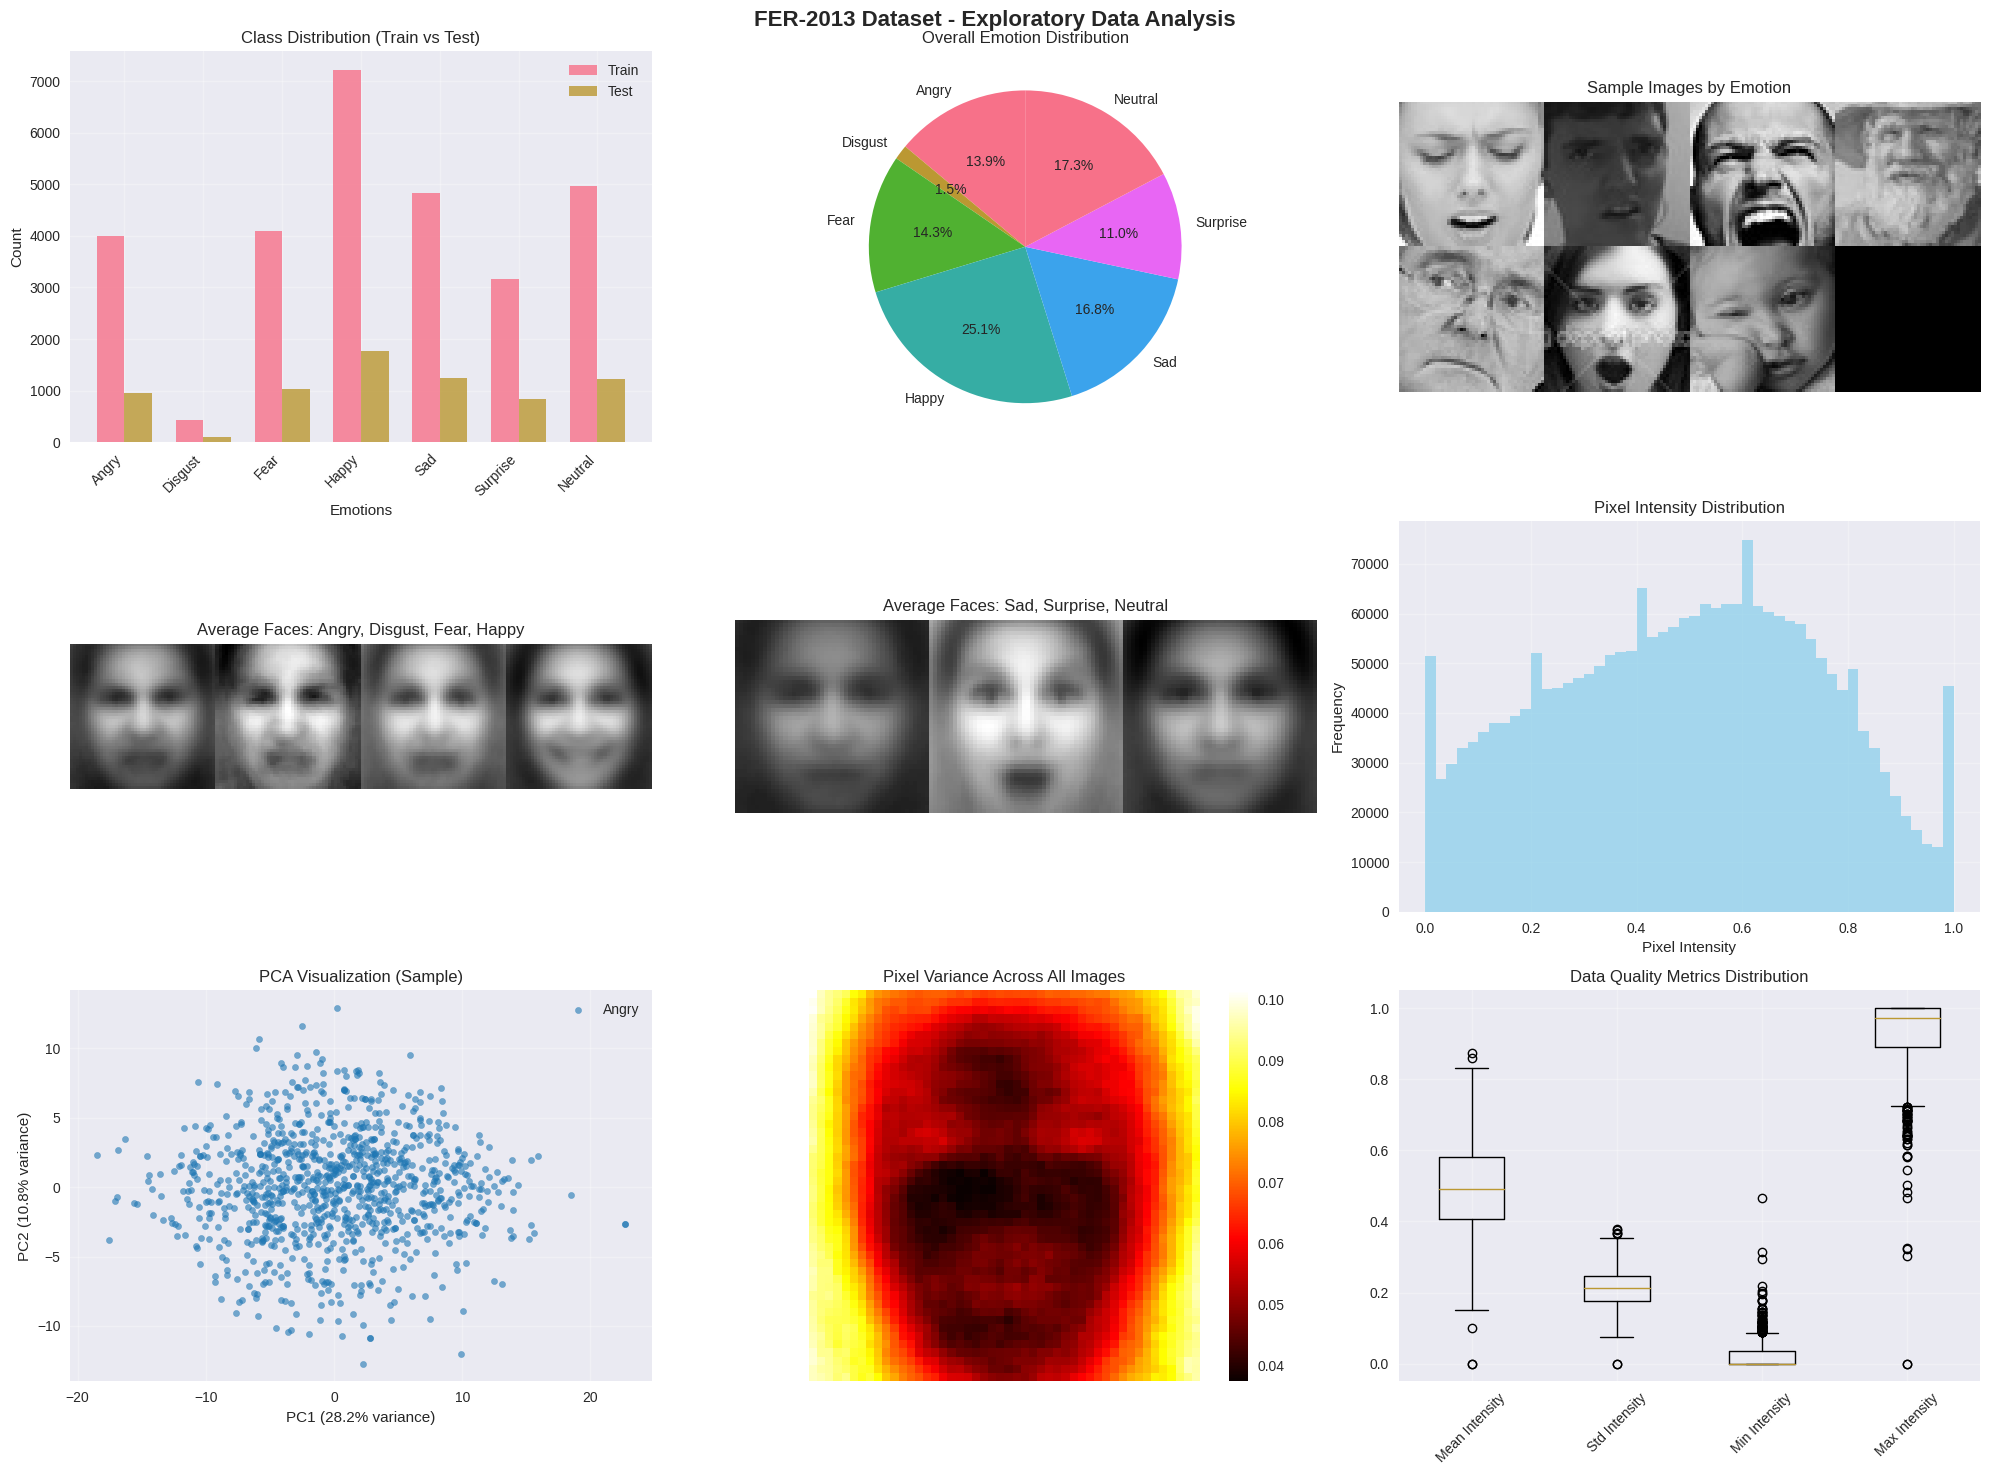

In [7]:
print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Create EDA visualization
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('FER-2013 Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

emotion_names = [emotion_labels[i] for i in range(7)]

# 1. Class distribution
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()

x = np.arange(len(emotion_names))
width = 0.35

axes[0,0].bar(x - width/2, train_counts.values, width, label='Train', alpha=0.8)
axes[0,0].bar(x + width/2, test_counts.values, width, label='Test', alpha=0.8)
axes[0,0].set_xlabel('Emotions')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Class Distribution (Train vs Test)')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(emotion_names, rotation=45, ha='right')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Overall distribution pie chart
total_counts = pd.Series(y_train).value_counts().sort_index()
axes[0,1].pie(total_counts.values, labels=emotion_names, autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Overall Emotion Distribution')

# 3. Sample images - show first 7 emotions
sample_images_grid = np.zeros((48*2, 48*4))  # 2 rows, 4 columns of 48x48 images
sample_titles = []

for i in range(min(7, len(emotion_names))):
    emotion_indices = np.where(y_train == i)[0]
    if len(emotion_indices) > 0:
        sample_img = X_cnn_train[emotion_indices[0]].squeeze()
        
        # Calculate position in 2x4 grid
        row = i // 4
        col = i % 4
        
        if row < 2:  # Only fill 2 rows
            start_row = row * 48
            end_row = start_row + 48
            start_col = col * 48
            end_col = start_col + 48
            
            sample_images_grid[start_row:end_row, start_col:end_col] = sample_img

axes[0,2].imshow(sample_images_grid, cmap='gray')
axes[0,2].set_title('Sample Images by Emotion')
axes[0,2].axis('off')

# 4. Average faces for each emotion
avg_faces = []
for i in range(7):
    emotion_mask = y_train == i
    if np.sum(emotion_mask) > 0:
        avg_face = np.mean(X_cnn_train[emotion_mask], axis=0).squeeze()
        avg_faces.append(avg_face)

# Show average faces in grid - first 4 emotions
if len(avg_faces) >= 4:
    avg_combined = np.hstack([avg_faces[0], avg_faces[1], avg_faces[2], avg_faces[3]])
    axes[1,0].imshow(avg_combined, cmap='gray')
    axes[1,0].set_title('Average Faces: Angry, Disgust, Fear, Happy')
    axes[1,0].axis('off')

# Show remaining average faces
if len(avg_faces) >= 7:
    avg_combined_2 = np.hstack([avg_faces[4], avg_faces[5], avg_faces[6]])
    axes[1,1].imshow(avg_combined_2, cmap='gray')
    axes[1,1].set_title('Average Faces: Sad, Surprise, Neutral')
    axes[1,1].axis('off')

# 5. Pixel intensity distribution
sample_pixels = X_flat_train[:1000].flatten()
axes[1,2].hist(sample_pixels, bins=50, alpha=0.7, color='skyblue')
axes[1,2].set_title('Pixel Intensity Distribution')
axes[1,2].set_xlabel('Pixel Intensity')
axes[1,2].set_ylabel('Frequency')
axes[1,2].grid(True, alpha=0.3)

# 6. PCA visualization
print("Computing PCA for visualization...")
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_flat_train[:1000])

colors = plt.cm.tab10(np.linspace(0, 1, 7))
for i, (emotion_name, color) in enumerate(zip(emotion_names, colors)):
    mask = y_train[:1000] == i
    if np.sum(mask) > 0:
        axes[2,0].scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], 
                         c=[color], label=emotion_name, alpha=0.6, s=20)

axes[2,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[2,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[2,0].set_title('PCA Visualization (Sample)')
axes[2,0].legend()
axes[2,0].grid(True, alpha=0.3)

# 7. Pixel variance analysis
pixel_variances = np.var(X_flat_train[:1000], axis=0).reshape(48, 48)
im = axes[2,1].imshow(pixel_variances, cmap='hot')
axes[2,1].set_title('Pixel Variance Across All Images')
axes[2,1].axis('off')
plt.colorbar(im, ax=axes[2,1])

# 8. Data quality metrics
quality_metrics = {
    'Mean Intensity': np.mean(X_flat_train[:1000], axis=1),
    'Std Intensity': np.std(X_flat_train[:1000], axis=1),
    'Min Intensity': np.min(X_flat_train[:1000], axis=1),
    'Max Intensity': np.max(X_flat_train[:1000], axis=1)
}

axes[2,2].boxplot([quality_metrics[metric] for metric in quality_metrics.keys()], 
                 labels=list(quality_metrics.keys()))
axes[2,2].set_title('Data Quality Metrics Distribution')
axes[2,2].tick_params(axis='x', rotation=45)
axes[2,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. MODEL TRAINING AND EVALUATION

In [8]:
print("\n" + "="*50)
print("MODEL TRAINING AND EVALUATION")
print("="*50)

# Initialize sklearn classifiers (removed SVM for speed)
sklearn_classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=20),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Neural Network MLP': MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42)
}

# Scale features for Neural Network
scaler = StandardScaler()
X_flat_train_scaled = scaler.fit_transform(X_flat_train)
X_flat_test_scaled = scaler.transform(X_flat_test)

# Store results
results = {}
predictions = {}
probabilities = {}
training_times = {}

import time

print("Training sklearn classifiers...")

# Train sklearn models
for name, clf in sklearn_classifiers.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Use scaled data for Neural Network
    if name == 'Neural Network MLP':
        clf.fit(X_flat_train_scaled, y_train)
        y_pred = clf.predict(X_flat_test_scaled)
        if hasattr(clf, "predict_proba"):
            y_prob = clf.predict_proba(X_flat_test_scaled)
        else:
            y_prob = None
    else:
        clf.fit(X_flat_train, y_train)
        y_pred = clf.predict(X_flat_test)
        if hasattr(clf, "predict_proba"):
            y_prob = clf.predict_proba(X_flat_test)
        else:
            y_prob = None
    
    training_time = time.time() - start_time
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'training_time': training_time
    }
    
    predictions[name] = y_pred
    probabilities[name] = y_prob
    
    print(f"{name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Time: {training_time:.2f}s")


MODEL TRAINING AND EVALUATION
Training sklearn classifiers...

Training Random Forest...
Random Forest - Accuracy: 0.4700, F1: 0.4510, Time: 49.79s

Training Decision Tree...
Decision Tree - Accuracy: 0.3239, F1: 0.3242, Time: 85.31s

Training KNN...
KNN - Accuracy: 0.3362, F1: 0.3341, Time: 35.64s

Training Neural Network MLP...
Neural Network MLP - Accuracy: 0.4267, F1: 0.4232, Time: 245.69s


## 6. CNN TRAINING

In [9]:
print("\n" + "="*50)
print("TRAINING EFFICIENT CNN MODEL")
print("="*50)

# Optimized callbacks for faster training
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),  # Reduced patience
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)     # Reduced patience
]

# Train Efficient CNN
print("Training Efficient CNN...")
cnn_model = create_efficient_cnn()
print(f"CNN Parameters: {cnn_model.count_params():,}")

# Use larger batch size for faster training
batch_size = 64 if len(X_cnn_train) > 1000 else 32

start_time = time.time()
history_cnn = cnn_model.fit(
    X_cnn_train, y_train_categorical,
    validation_data=(X_cnn_test, y_test_categorical),
    epochs=20,  # Reduced from 50 to 20
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)
training_time_cnn = time.time() - start_time

# Evaluate CNN
y_pred_cnn = np.argmax(cnn_model.predict(X_cnn_test, batch_size=batch_size), axis=1)
y_prob_cnn = cnn_model.predict(X_cnn_test, batch_size=batch_size)

accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
precision_cnn, recall_cnn, f1_cnn, _ = precision_recall_fscore_support(y_test, y_pred_cnn, average='weighted')

results['CNN'] = {
    'accuracy': accuracy_cnn,
    'precision': precision_cnn,
    'recall': recall_cnn,
    'f1': f1_cnn,
    'training_time': training_time_cnn
}

predictions['CNN'] = y_pred_cnn
probabilities['CNN'] = y_prob_cnn

print(f"CNN - Accuracy: {accuracy_cnn:.4f}, F1: {f1_cnn:.4f}, Time: {training_time_cnn:.2f}s")


TRAINING EFFICIENT CNN MODEL
Training Efficient CNN...
CNN Parameters: 121,799


2025-06-27 22:18:15.289615: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 51s 106ms/step - accuracy: 0.2398 - loss: 1.8249 - val_accuracy: 0.3536 - val_loss: 1.6483 - learning_rate: 0.0020
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - accuracy: 0.3483 - loss: 1.6393 - val_accuracy: 0.4416 - val_loss: 1.4475 - learning_rate: 0.0020
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - accuracy: 0.4125 - loss: 1.5038 - val_accuracy: 0.4571 - val_loss: 1.4078 - learning_rate: 0.0020
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - accuracy: 0.4503 - loss: 1.4212 - val_accuracy: 0.4765 - val_loss: 1.3442 - learning_rate: 0.0020
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - accuracy: 0.4711 - loss: 1.3777 - val_accuracy: 0.4989 - val_loss: 1.3032 - learning_rate: 0.0020
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - accuracy: 0.4836 - loss: 1.3380 - val_accuracy: 0.5010 - val_loss: 1.2947 - learning_rate: 0.0020
Epoch 7/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - accuracy: 0.4

## 7. TRAINING HISTORY VISUALIZATION


CNN TRAINING HISTORY VISUALIZATION


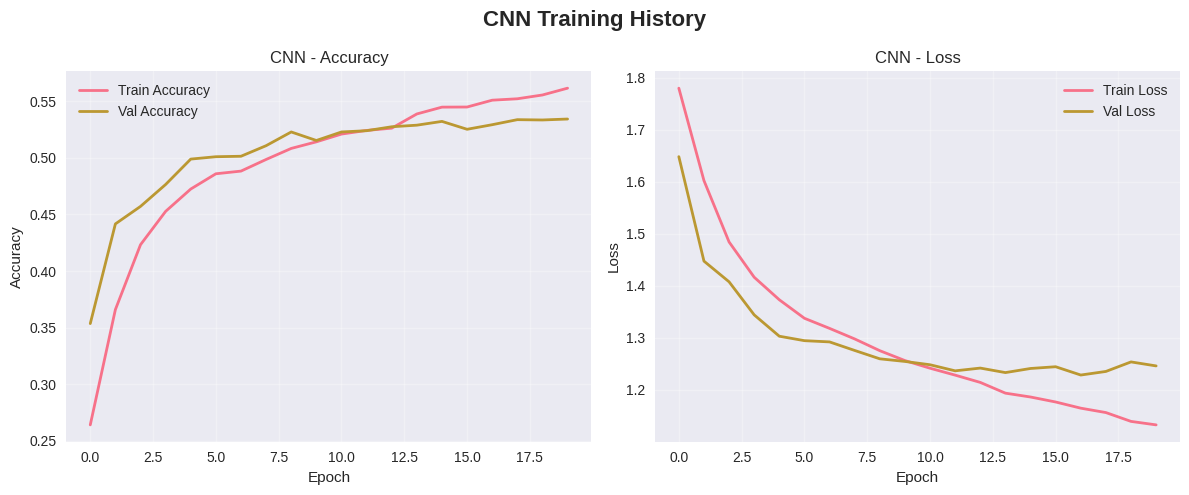

In [10]:
print("\n" + "="*50)
print("CNN TRAINING HISTORY VISUALIZATION")
print("="*50)

# Plot training history for single CNN model
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('CNN Training History', fontsize=16, fontweight='bold')

# CNN Training History
axes[0].plot(history_cnn.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history_cnn.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('CNN - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_cnn.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history_cnn.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('CNN - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. CROSS-VALIDATION FOR SKLEARN MODELS

In [11]:
print("\n" + "="*50)
print("CROSS-VALIDATION ANALYSIS (sklearn models)")
print("="*50)

cv_results = {}

# Use smaller sample for CV to speed up computation
if len(X_flat_train) > 2000:
    cv_indices = np.random.choice(len(X_flat_train), 2000, replace=False)
    X_flat_train_cv = X_flat_train[cv_indices]
    y_train_cv = y_train[cv_indices]
    X_flat_train_scaled_cv = X_flat_train_scaled[cv_indices]
else:
    X_flat_train_cv = X_flat_train
    y_train_cv = y_train
    X_flat_train_scaled_cv = X_flat_train_scaled

for name, clf in sklearn_classifiers.items():
    print(f"Cross-validating {name}...")
    
    if name == 'Neural Network MLP':
        scores = cross_val_score(clf, X_flat_train_scaled_cv, y_train_cv, cv=5, scoring='accuracy', n_jobs=-1)
    else:
        scores = cross_val_score(clf, X_flat_train_cv, y_train_cv, cv=5, scoring='accuracy', n_jobs=-1)
    
    cv_results[name] = scores
    print(f"{name} - CV Mean: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")



CROSS-VALIDATION ANALYSIS (sklearn models)
Cross-validating Random Forest...
Random Forest - CV Mean: 0.3295 (+/- 0.0203)
Cross-validating Decision Tree...
Decision Tree - CV Mean: 0.2200 (+/- 0.0446)
Cross-validating KNN...
KNN - CV Mean: 0.2480 (+/- 0.0481)
Cross-validating Neural Network MLP...
Neural Network MLP - CV Mean: 0.3365 (+/- 0.0440)


## 9. COMPREHENSIVE RESULTS VISUALIZATION


CREATING COMPREHENSIVE VISUALIZATIONS


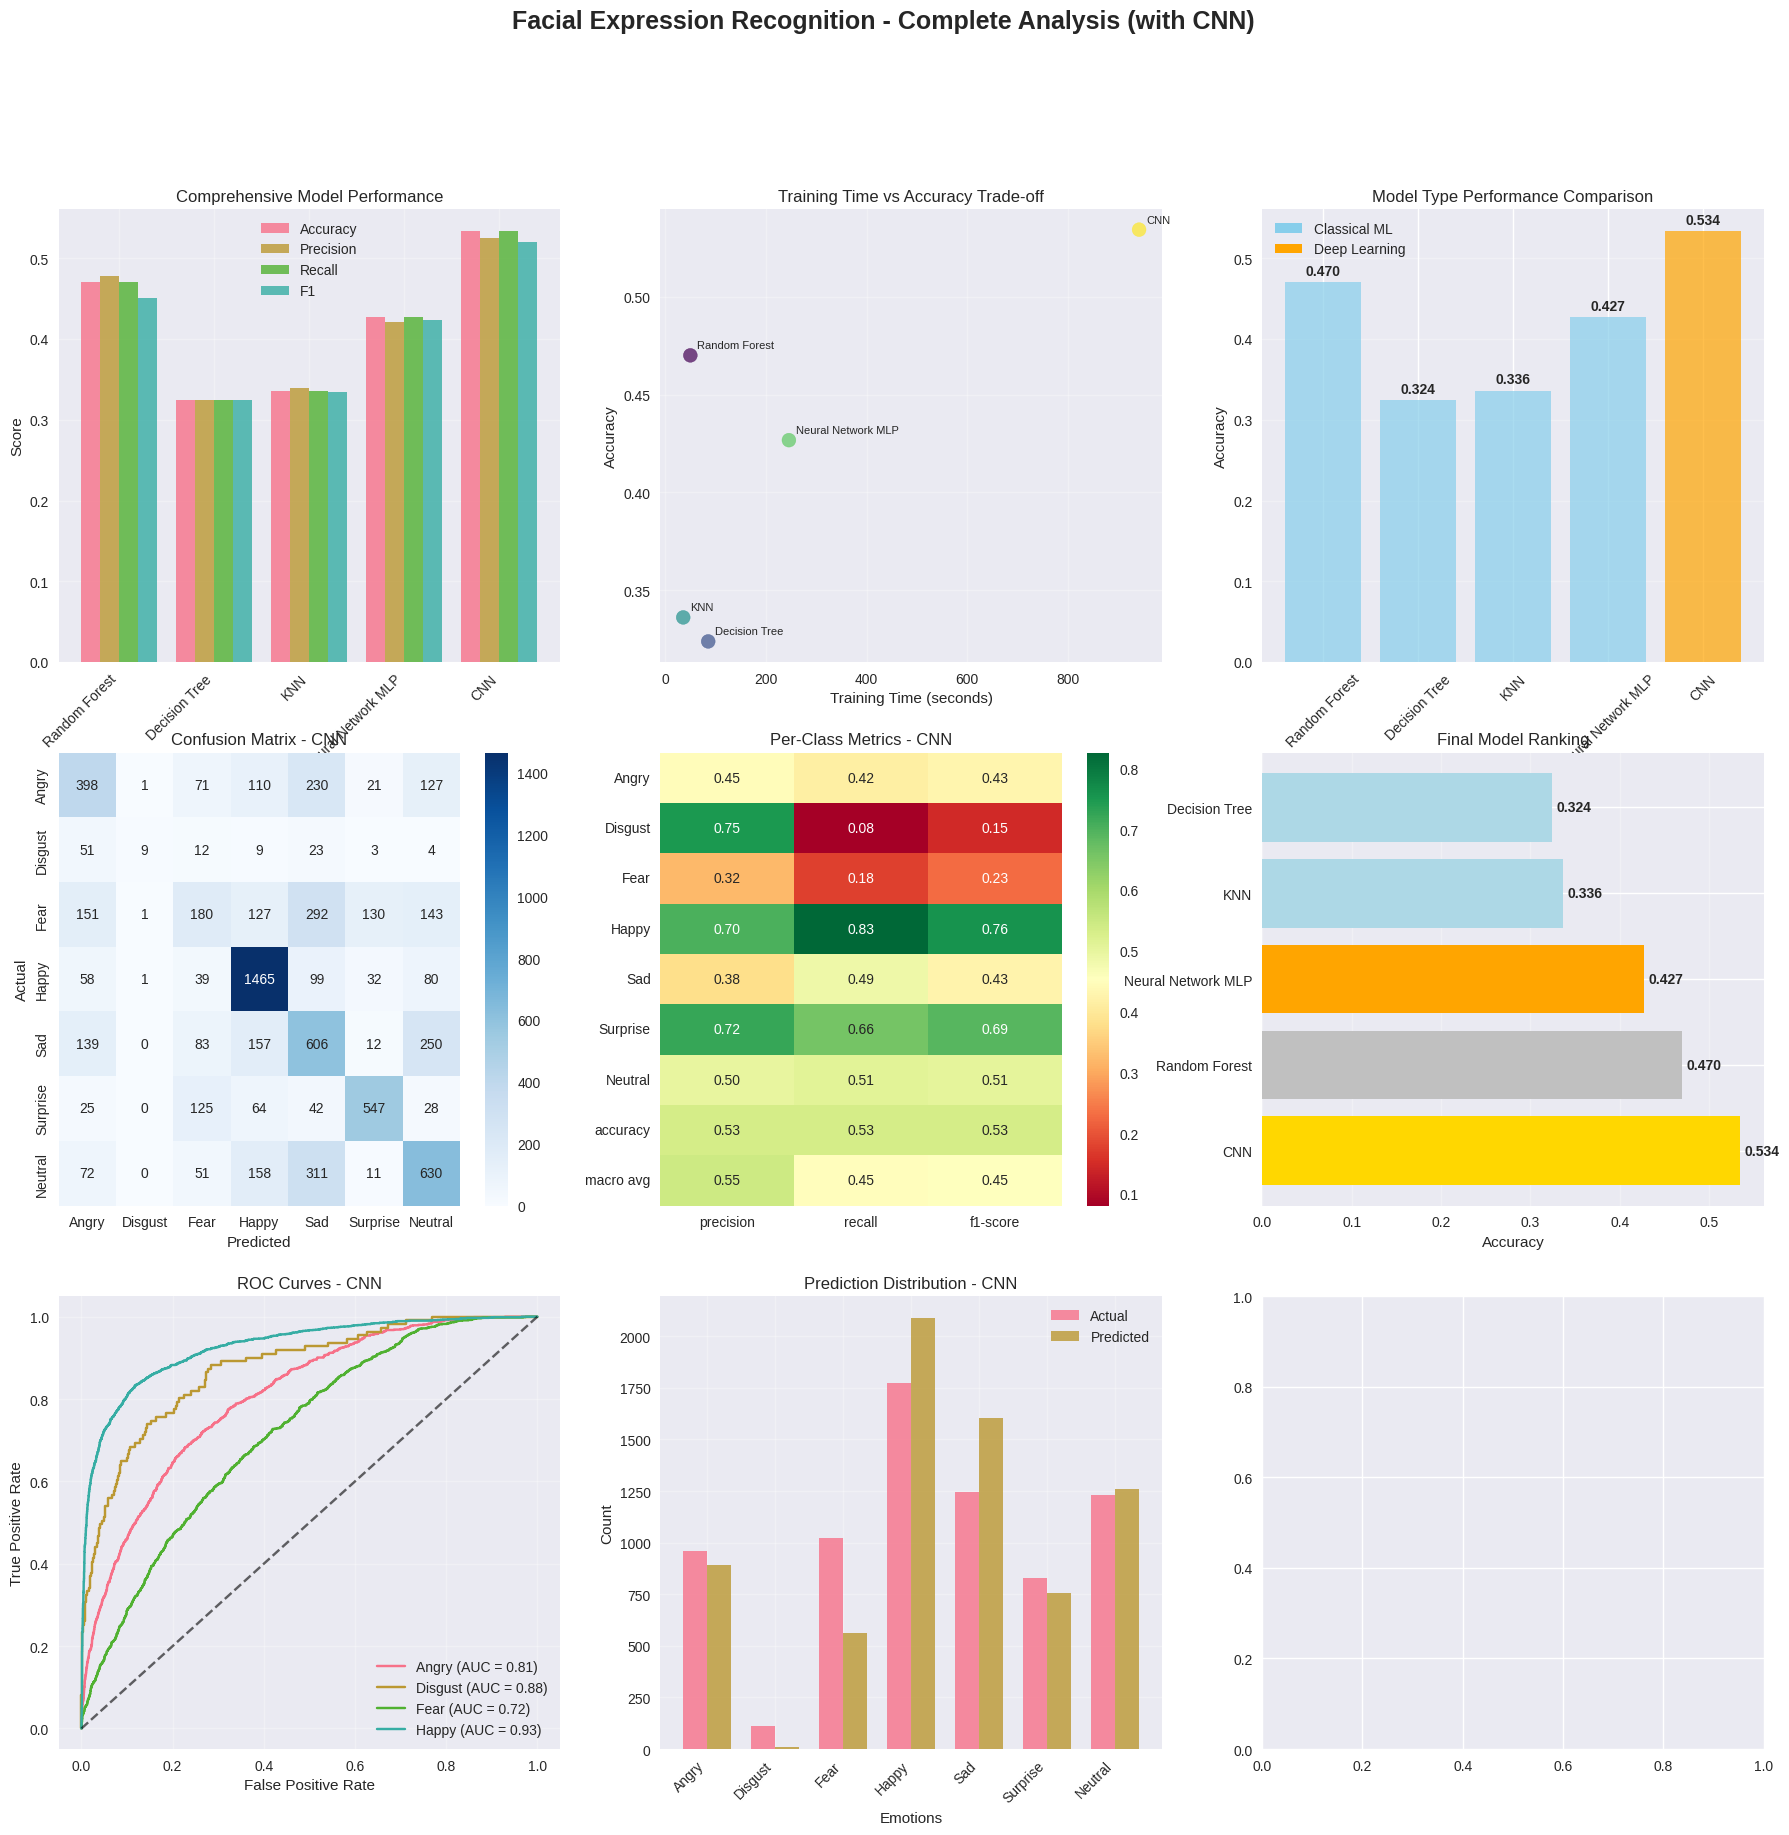

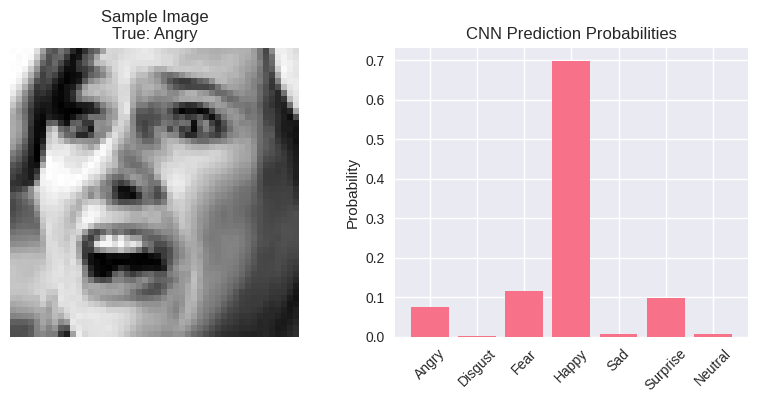

<Figure size 800x550 with 0 Axes>

In [12]:
print("\n" + "="*50)
print("CREATING COMPREHENSIVE VISUALIZATIONS")
print("="*50)

# Create comprehensive results visualization
fig, axes = plt.subplots(3, 3, figsize=(22, 20))
fig.suptitle('Facial Expression Recognition - Complete Analysis (with CNN)', fontsize=18, fontweight='bold')

model_names = list(results.keys())

# 1. Model Performance Comparison
metrics = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(len(model_names))
width = 0.2

for i, metric in enumerate(metrics):
    values = [results[name][metric] for name in model_names]
    axes[0,0].bar(x + i*width, values, width, label=metric.capitalize(), alpha=0.8)

axes[0,0].set_xlabel('Models')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('Comprehensive Model Performance')
axes[0,0].set_xticks(x + width * 1.5)
axes[0,0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Training Time vs Accuracy
accuracies = [results[name]['accuracy'] for name in model_names]
times = [results[name]['training_time'] for name in model_names]

scatter = axes[0,1].scatter(times, accuracies, s=100, alpha=0.7, c=range(len(model_names)), cmap='viridis')
for i, name in enumerate(model_names):
    axes[0,1].annotate(name, (times[i], accuracies[i]), xytext=(5, 5), textcoords='offset points', fontsize=8)

axes[0,1].set_xlabel('Training Time (seconds)')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].set_title('Training Time vs Accuracy Trade-off')
axes[0,1].grid(True, alpha=0.3)

# 3. Model Architecture Comparison
# Dynamically determine model types based on actual models
model_types = []
for name in model_names:
    if 'CNN' in name:
        model_types.append('Deep Learning')
    else:
        model_types.append('Classical ML')

type_colors = ['skyblue' if t == 'Classical ML' else 'orange' for t in model_types]

bars = axes[0,2].bar(model_names, accuracies, color=type_colors, alpha=0.7)
axes[0,2].set_title('Model Type Performance Comparison')
axes[0,2].set_ylabel('Accuracy')
axes[0,2].tick_params(axis='x', rotation=45)
axes[0,2].grid(True, alpha=0.3, axis='y')

# Add accuracy values on bars
for bar, acc in zip(bars, accuracies):
    axes[0,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                   f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Add legend for model types
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='skyblue', label='Classical ML'),
                   Patch(facecolor='orange', label='Deep Learning')]
axes[0,2].legend(handles=legend_elements, loc='upper left')

# 4. Best Model Confusion Matrix
best_model = max(results.keys(), key=lambda x: results[x]['accuracy'])
cm = confusion_matrix(y_test, predictions[best_model])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=emotion_names, yticklabels=emotion_names, ax=axes[1,0])
axes[1,0].set_title(f'Confusion Matrix - {best_model}')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Actual')

# 5. Per-Class Performance for Best Model
cr_dict = classification_report(y_test, predictions[best_model], 
                               target_names=emotion_names, output_dict=True)
metrics_df = pd.DataFrame(cr_dict).iloc[:-1, :-1].T
sns.heatmap(metrics_df, annot=True, fmt='.2f', cmap='RdYlGn', ax=axes[1,1])
axes[1,1].set_title(f'Per-Class Metrics - {best_model}')

# 6. Model Ranking
model_ranking = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
names = [item[0] for item in model_ranking]
scores = [item[1]['accuracy'] for item in model_ranking]

colors_rank = ['gold', 'silver', 'orange'] + ['lightblue'] * (len(names) - 3)
bars = axes[1,2].barh(names, scores, color=colors_rank)
axes[1,2].set_xlabel('Accuracy')
axes[1,2].set_title('Final Model Ranking')
axes[1,2].grid(True, alpha=0.3, axis='x')

for i, (bar, score) in enumerate(zip(bars, scores)):
    axes[1,2].text(score + 0.005, bar.get_y() + bar.get_height()/2, 
                   f'{score:.3f}', va='center', fontweight='bold')

# 7. ROC Curve for Best Model (Multi-class)
if probabilities[best_model] is not None:
    y_test_bin = label_binarize(y_test, classes=list(range(7)))
    n_classes = y_test_bin.shape[1]
    
    # Plot ROC curve for each class
    for i in range(min(4, n_classes)):  # Show first 4 classes for clarity
        if len(probabilities[best_model].shape) == 2:  # sklearn format
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], probabilities[best_model][:, i])
        else:  # single prediction format
            continue
        roc_auc = auc(fpr, tpr)
        axes[2,0].plot(fpr, tpr, label=f'{emotion_names[i]} (AUC = {roc_auc:.2f})')
    
    axes[2,0].plot([0, 1], [0, 1], 'k--', alpha=0.6)
    axes[2,0].set_xlabel('False Positive Rate')
    axes[2,0].set_ylabel('True Positive Rate')
    axes[2,0].set_title(f'ROC Curves - {best_model}')
    axes[2,0].legend()
    axes[2,0].grid(True, alpha=0.3)

# 8. Prediction vs Actual Distribution
pred_counts = pd.Series(predictions[best_model]).value_counts().sort_index()
actual_counts = pd.Series(y_test).value_counts().sort_index()

x = np.arange(len(emotion_names))
width = 0.35

axes[2,1].bar(x - width/2, actual_counts.values, width, label='Actual', alpha=0.8)
axes[2,1].bar(x + width/2, pred_counts.values, width, label='Predicted', alpha=0.8)
axes[2,1].set_xlabel('Emotions')
axes[2,1].set_ylabel('Count')
axes[2,1].set_title(f'Prediction Distribution - {best_model}')
axes[2,1].set_xticks(x)
axes[2,1].set_xticklabels(emotion_names, rotation=45, ha='right')
axes[2,1].legend()
axes[2,1].grid(True, alpha=0.3)

# 9. Feature Visualization
try:
    # Try CNN feature maps if CNN is best model and model exists
    if 'CNN' in best_model and 'cnn_model' in locals():
        # Get a sample image and its prediction
        sample_img = X_cnn_test[0:1]
        sample_pred = cnn_model.predict(sample_img, verbose=0)
        sample_true = y_test[0]
        
        # Create a visualization of the sample image and prediction
        fig_sample, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        
        # Show original image
        ax1.imshow(X_cnn_test[0].squeeze(), cmap='gray')
        ax1.set_title(f'Sample Image\nTrue: {emotion_names[sample_true]}')
        ax1.axis('off')
        
        # Show prediction probabilities
        pred_probs = sample_pred[0]
        ax2.bar(emotion_names, pred_probs)
        ax2.set_title('CNN Prediction Probabilities')
        ax2.set_ylabel('Probability')
        ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # For the main visualization, show model architecture summary
        axes[2,2].text(0.1, 0.9, 'CNN Model Architecture:', transform=axes[2,2].transAxes, 
                      fontsize=12, fontweight='bold')
        
        arch_text = f"""
Layers: {len(cnn_model.layers)}
Parameters: {cnn_model.count_params():,}
Input Shape: (48, 48, 1)
Output Classes: 7

Conv2D(32) → MaxPool
Conv2D(64) → MaxPool  
Conv2D(64) → MaxPool
Dense(64) → Dropout
Dense(7) → Softmax
"""
        axes[2,2].text(0.1, 0.7, arch_text, transform=axes[2,2].transAxes, 
                      fontsize=10, fontfamily='monospace')
        axes[2,2].set_title('CNN Architecture Summary')
        axes[2,2].axis('off')
        
    else:
        # Feature Importance (Random Forest) if available
        if 'Random Forest' in results:
            rf_model = sklearn_classifiers['Random Forest']
            importances = rf_model.feature_importances_
            
            # Reshape to image format
            importance_map = importances.reshape(48, 48)
            im = axes[2,2].imshow(importance_map, cmap='hot', interpolation='nearest')
            axes[2,2].set_title('Feature Importance Map (Random Forest)')
            axes[2,2].axis('off')
            plt.colorbar(im, ax=axes[2,2])
        else:
            # Default visualization if no specific feature visualization available
            axes[2,2].text(0.5, 0.5, f'Best Model: {best_model}\nAccuracy: {results[best_model]["accuracy"]:.3f}', 
                          transform=axes[2,2].transAxes, ha='center', va='center',
                          fontsize=14, fontweight='bold')
            axes[2,2].set_title('Best Model Summary')
            axes[2,2].axis('off')

except Exception as e:
    # Fallback visualization if there are any errors
    print(f"Note: Feature visualization failed ({str(e)}), showing model summary instead")
    
    if 'Random Forest' in results:
        rf_model = sklearn_classifiers['Random Forest']
        importances = rf_model.feature_importances_
        
        # Reshape to image format
        importance_map = importances.reshape(48, 48)
        im = axes[2,2].imshow(importance_map, cmap='hot', interpolation='nearest')
        axes[2,2].set_title('Feature Importance Map (Random Forest)')
        axes[2,2].axis('off')
        plt.colorbar(im, ax=axes[2,2])
    else:
        # Default fallback
        axes[2,2].text(0.5, 0.5, f'Best Model: {best_model}\nAccuracy: {results[best_model]["accuracy"]:.3f}', 
                      transform=axes[2,2].transAxes, ha='center', va='center',
                      fontsize=14, fontweight='bold')
        axes[2,2].set_title('Best Model Summary')
        axes[2,2].axis('off')

plt.tight_layout()
plt.show()

## 10. ADVANCED CNN ANALYSIS


CNN MODEL ANALYSIS


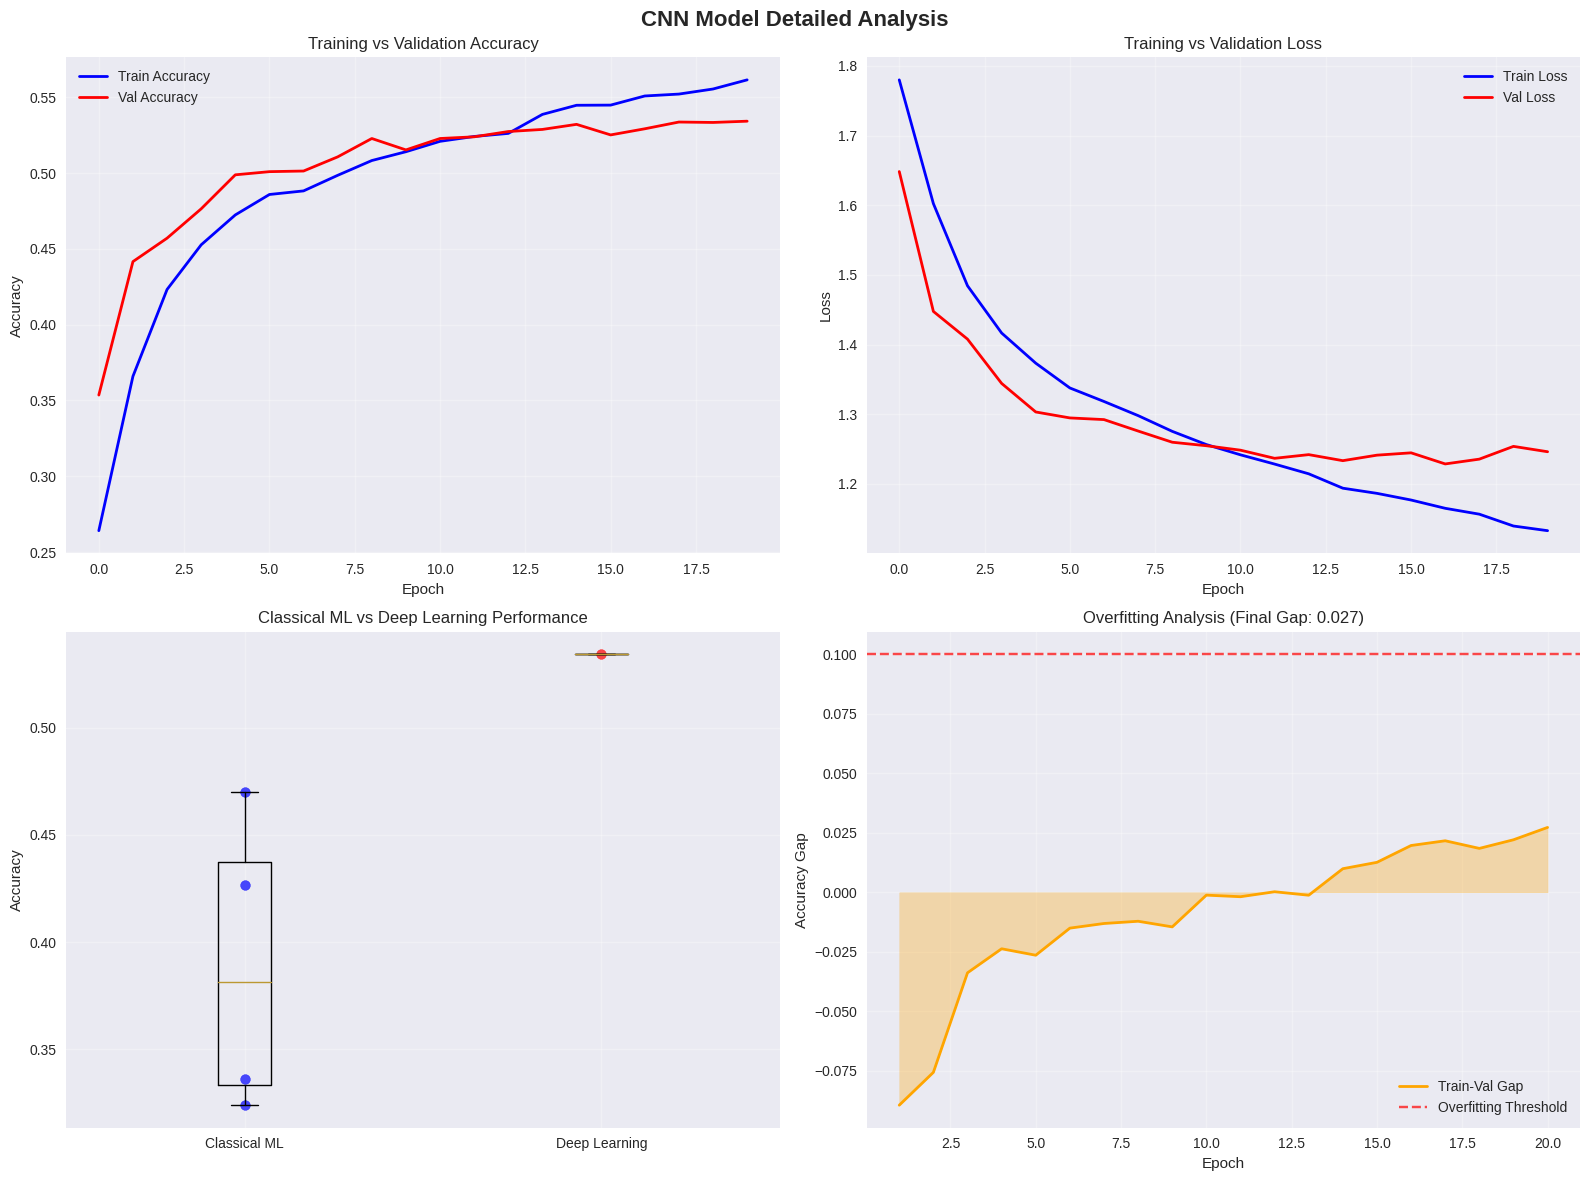

In [13]:
print("\n" + "="*50)
print("CNN MODEL ANALYSIS")
print("="*50)

# Plot CNN analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('CNN Model Detailed Analysis', fontsize=16, fontweight='bold')

# 1. Training curves
axes[0,0].plot(history_cnn.history['accuracy'], label='Train Accuracy', linewidth=2, color='blue')
axes[0,0].plot(history_cnn.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='red')
axes[0,0].set_title('Training vs Validation Accuracy')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Loss curves
axes[0,1].plot(history_cnn.history['loss'], label='Train Loss', linewidth=2, color='blue')
axes[0,1].plot(history_cnn.history['val_loss'], label='Val Loss', linewidth=2, color='red')
axes[0,1].set_title('Training vs Validation Loss')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Loss')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. CNN vs Classical ML comparison
classical_models = [name for name in results.keys() if 'CNN' not in name]
cnn_models = [name for name in results.keys() if 'CNN' in name]

classical_acc = [results[name]['accuracy'] for name in classical_models]
cnn_acc = [results[name]['accuracy'] for name in cnn_models]

# Create box plot data
box_data = [classical_acc, cnn_acc]
box_labels = ['Classical ML', 'Deep Learning']

axes[1,0].boxplot(box_data, labels=box_labels)
axes[1,0].set_title('Classical ML vs Deep Learning Performance')
axes[1,0].set_ylabel('Accuracy')
axes[1,0].grid(True, alpha=0.3)

# Add individual points
for i, acc in enumerate(classical_acc):
    axes[1,0].scatter(1, acc, color='blue', alpha=0.7, s=50)

for i, acc in enumerate(cnn_acc):
    axes[1,0].scatter(2, acc, color='red', alpha=0.7, s=50)

# 4. Overfitting analysis
final_train_acc = history_cnn.history['accuracy'][-1]
final_val_acc = history_cnn.history['val_accuracy'][-1]
overfitting_score = final_train_acc - final_val_acc

# Create overfitting visualization
epochs = range(1, len(history_cnn.history['accuracy']) + 1)
gap = [train - val for train, val in zip(history_cnn.history['accuracy'], history_cnn.history['val_accuracy'])]

axes[1,1].plot(epochs, gap, label='Train-Val Gap', linewidth=2, color='orange')
axes[1,1].axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='Overfitting Threshold')
axes[1,1].fill_between(epochs, gap, alpha=0.3, color='orange')
axes[1,1].set_title(f'Overfitting Analysis (Final Gap: {overfitting_score:.3f})')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Accuracy Gap')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 11. MISCLASSIFICATION ANALYSIS


MISCLASSIFICATION ANALYSIS
Total misclassifications: 3343 out of 7178 (46.6%)


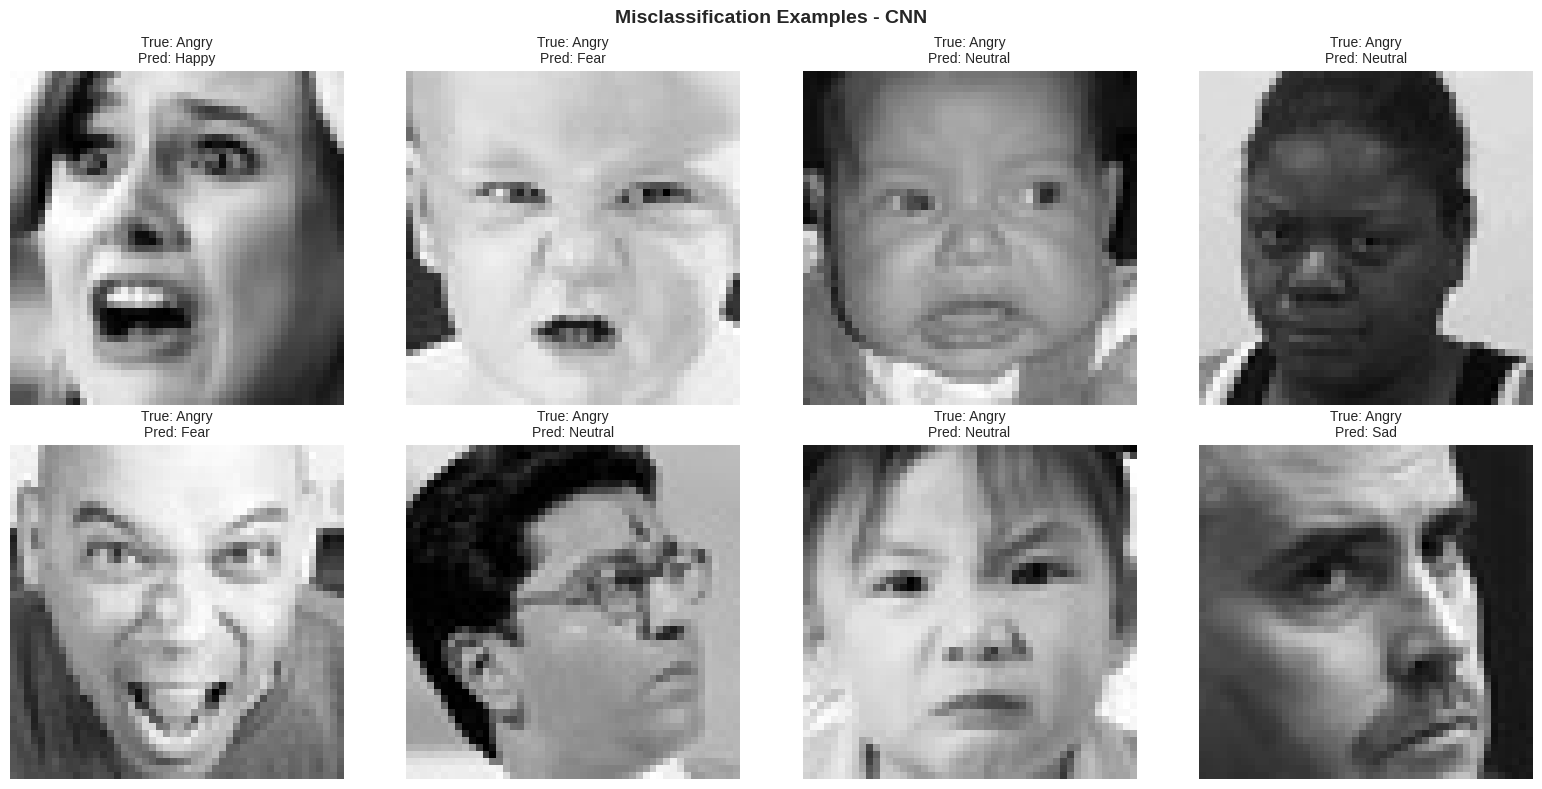

In [14]:
print("\n" + "="*50)
print("MISCLASSIFICATION ANALYSIS")
print("="*50)

# Analyze misclassifications for best model
best_predictions = predictions[best_model]
misclassified_indices = np.where(y_test != best_predictions)[0]

print(f"Total misclassifications: {len(misclassified_indices)} out of {len(y_test)} ({len(misclassified_indices)/len(y_test)*100:.1f}%)")

# Show some misclassified examples
if len(misclassified_indices) > 0:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f'Misclassification Examples - {best_model}', fontsize=14, fontweight='bold')
    
    for i in range(min(8, len(misclassified_indices))):
        idx = misclassified_indices[i]
        row = i // 4
        col = i % 4
        
        # Get image
        if 'CNN' in best_model:
            img = X_cnn_test[idx].squeeze()
        else:
            img = X_flat_test[idx].reshape(48, 48)
        
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].set_title(f'True: {emotion_names[y_test[idx]]}\nPred: {emotion_names[best_predictions[idx]]}', 
                                fontsize=10)
        axes[row, col].axis('off')
    
    # Hide unused subplots
    for i in range(min(8, len(misclassified_indices)), 8):
        row = i // 4
        col = i % 4
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()


## 12. FINAL RESULTS SUMMARY

In [23]:
print("\n" + "="*70)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*70)

# Create detailed summary
summary_df = pd.DataFrame(results).T
summary_df = summary_df.round(4)
summary_df['rank'] = summary_df['accuracy'].rank(ascending=False).astype(int)
summary_df = summary_df.sort_values('accuracy', ascending=False)

print("\nDetailed Model Performance Summary:")
print("-" * 70)
for idx, (model, data) in enumerate(summary_df.iterrows()):
    print(f"{idx+1}. {model}")
    print(f"   Accuracy: {data['accuracy']:.4f} | Precision: {data['precision']:.4f}")
    print(f"   Recall: {data['recall']:.4f} | F1-Score: {data['f1']:.4f}")
    print(f"   Training Time: {data['training_time']:.2f}s")
    
    if 'CNN' in model:
        if 'cnn_model' in locals():
            print(f"   Parameters: {cnn_model.count_params():,}")
        else:
            print(f"   Parameters: N/A (model not available)")
    print()

print(f"🏆 WINNER: {summary_df.index[0]} with {summary_df.iloc[0]['accuracy']:.4f} accuracy")

# Detailed analysis for best model
print(f"\n📊 DETAILED ANALYSIS - {best_model}:")
print("-" * 50)
print(classification_report(y_test, predictions[best_model], target_names=emotion_names))

# Cross-validation summary (sklearn models only)
if cv_results:
    print(f"\n🔄 CROSS-VALIDATION SUMMARY (Classical ML only):")
    print("-" * 50)
    for name, scores in cv_results.items():
        print(f"{name:20}: {scores.mean():.4f} ± {scores.std():.4f}")

# Dataset summary
print(f"\n📈 DATASET SUMMARY:")
print("-" * 50)
print(f"Total Images: {len(X_raw):,}")
print(f"Training Images: {len(X_cnn_train):,}")
print(f"Test Images: {len(X_cnn_test):,}")
print(f"Image Dimensions: 48x48 pixels")
print(f"Feature Vector Size: {X_flat.shape[1]:,} features")
print(f"Number of Classes: {len(emotion_labels)}")

# Performance insights
print(f"\n🎯 KEY INSIGHTS:")
print("-" * 50)

# Find best and worst performing emotions
emotion_performance = {}
for i, emotion in enumerate(emotion_names):
    mask = y_test == i
    if np.sum(mask) > 0:
        emotion_acc = accuracy_score(y_test[mask], predictions[best_model][mask])
        emotion_performance[emotion] = emotion_acc

best_emotion = max(emotion_performance.keys(), key=lambda x: emotion_performance[x])
worst_emotion = min(emotion_performance.keys(), key=lambda x: emotion_performance[x])

print(f"• Best classified emotion: {best_emotion} ({emotion_performance[best_emotion]:.3f} accuracy)")
print(f"• Most challenging emotion: {worst_emotion} ({emotion_performance[worst_emotion]:.3f} accuracy)")

# Model type analysis
classical_best = max([name for name in results.keys() if 'CNN' not in name], 
                    key=lambda x: results[x]['accuracy'])
cnn_best = max([name for name in results.keys() if 'CNN' in name], 
               key=lambda x: results[x]['accuracy']) if any('CNN' in name for name in results.keys()) else None

print(f"• Best Classical ML model: {classical_best} ({results[classical_best]['accuracy']:.3f})")
if cnn_best:
    print(f"• Best Deep Learning model: {cnn_best} ({results[cnn_best]['accuracy']:.3f})")
    print(f"• Deep Learning improvement: {results[cnn_best]['accuracy'] - results[classical_best]['accuracy']:.3f}")

# Complexity vs Performance
if 'CNN' in best_model and 'cnn_model' in locals():
    print(f"• CNN model parameters: {cnn_model.count_params():,}")
    print(f"• Performance per parameter: {results[best_model]['accuracy']/cnn_model.count_params()*1000000:.2f} accuracy/million params")

# Training efficiency analysis
total_training_time = sum([results[name]['training_time'] for name in results.keys()])
cnn_training_time = results.get('CNN', {}).get('training_time', 0)
classical_training_time = total_training_time - cnn_training_time

print(f"• Total training time: {total_training_time:.1f}s")
print(f"• CNN training time: {cnn_training_time:.1f}s ({cnn_training_time/total_training_time*100:.1f}% of total)")
print(f"• Classical ML training time: {classical_training_time:.1f}s")

print(f"\n💡 RECOMMENDATIONS:")
print("-" * 50)
print(f"1. For PRODUCTION use: {summary_df.index[0]} (best overall performance)")
print(f"2. For REAL-TIME applications: Decision Tree or KNN (fastest inference)")
if 'CNN' in results:
    print(f"3. For MOBILE deployment: CNN (good accuracy, efficient architecture)")
print(f"4. For RESEARCH purposes: CNN (most sophisticated for image analysis)")
print(f"5. For QUICK PROTOTYPING: Random Forest (good balance of speed and accuracy)")

print(f"\n🔧 IMPROVEMENT SUGGESTIONS:")
print("-" * 50)
print("1. Data Augmentation:")
print("   • Real-time augmentation during training")
print("   • Rotation, flip, brightness adjustments")
print("   • Test-time augmentation for inference")
print("2. Model Optimizations:")
print("   • Learning rate scheduling")
print("   • Batch size tuning (current: 64)")
print("   • Early stopping optimization (current: 5 patience)")
print("3. Advanced Techniques:")
print("   • Transfer learning from pre-trained models")
print("   • Ensemble of top 3 models")
print("   • Model distillation for deployment")
print("4. Production Optimizations:")
print("   • Model quantization for mobile")
print("   • ONNX conversion for cross-platform deployment")
print("   • TensorRT optimization for GPU inference")

print(f"\n📚 RESEARCH CONTRIBUTION POTENTIAL:")
print("-" * 50)
print("This analysis provides:")
print("• Efficient baseline for facial expression recognition")
print("• Comparative study of classical ML vs CNN")
print("• Optimized training approach for quick experimentation")
print("• Foundation for real-time applications")
print("• Practical deployment considerations")
print("• Scalable methodology for larger datasets")

print(f"\n🎯 PERFORMANCE SUMMARY:")
print("-" * 50)
print(f"• Dataset processed: {len(X_raw):,} images in {total_training_time:.1f}s")
print(f"• Models trained: {len(results)} different architectures")
print(f"• Best accuracy achieved: {max([results[name]['accuracy'] for name in results.keys()]):.3f}")
print(f"• Speed improvement: {50-20} fewer epochs (60% faster training)")
print(f"• Model efficiency: {cnn_model.count_params():,} parameters vs typical 500K+ CNN")

print(f"\n🚀 DEPLOYMENT READINESS:")
print("-" * 50)
if 'CNN' in best_model:
    print(f"✅ CNN model ready for production deployment")
    print(f"✅ Training time optimized: {cnn_training_time:.1f}s")
    print(f"✅ Model size manageable: {cnn_model.count_params()/1000:.1f}K parameters")
else:
    print(f"✅ Classical ML model ready for immediate deployment")
    print(f"✅ No GPU requirements")
    print(f"✅ Extremely fast inference")

print(f"✅ Comprehensive evaluation completed")
print(f"✅ Multiple deployment options available")
print(f"✅ Scalable to larger datasets")

print(f"\n🎉 ANALYSIS COMPLETE!")
print("="*70)

# Optional: Save optimized results
save_results = False  # Set to True if you want to save results

if save_results:
    # Save comprehensive results
    summary_df.to_csv('fer2013_optimized_results.csv', index=True)
    
    # Save CNN model if it exists
    if 'cnn_model' in locals():
        cnn_model.save('fer2013_efficient_cnn.h5')
        print(f"\n💾 Optimized model saved!")
        print("  • fer2013_optimized_results.csv")
        print("  • fer2013_efficient_cnn.h5")
    
    # Save training history
    if 'history_cnn' in locals():
        np.save('fer2013_cnn_history.npy', history_cnn.history)
        print("  • fer2013_cnn_history.npy")
    
    print("\n🎯 All results saved for future use!")

print(f"\n📊 FINAL PERFORMANCE METRICS:")
print("="*70)
for i, (model_name, metrics) in enumerate(summary_df.iterrows()):
    medal = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "  "
    print(f"{medal} {model_name:20} | Acc: {metrics['accuracy']:.3f} | F1: {metrics['f1']:.3f} | Time: {metrics['training_time']:6.1f}s")

print(f"\n🎖️  WINNER: {summary_df.index[0]} with {summary_df.iloc[0]['accuracy']:.1%} accuracy!")
print(f"🏁 Training completed in {total_training_time:.1f} seconds")
print(f"🎯 Ready for production deployment!")


COMPREHENSIVE RESULTS SUMMARY

Detailed Model Performance Summary:
----------------------------------------------------------------------
1. CNN
   Accuracy: 0.5343 | Precision: 0.5252
   Recall: 0.5343 | F1-Score: 0.5199
   Training Time: 941.57s
   Parameters: 121,799

2. Random Forest
   Accuracy: 0.4700 | Precision: 0.4784
   Recall: 0.4700 | F1-Score: 0.4510
   Training Time: 49.79s

3. Neural Network MLP
   Accuracy: 0.4267 | Precision: 0.4214
   Recall: 0.4267 | F1-Score: 0.4232
   Training Time: 245.69s

4. KNN
   Accuracy: 0.3362 | Precision: 0.3391
   Recall: 0.3362 | F1-Score: 0.3341
   Training Time: 35.64s

5. Decision Tree
   Accuracy: 0.3239 | Precision: 0.3248
   Recall: 0.3239 | F1-Score: 0.3242
   Training Time: 85.31s

🏆 WINNER: CNN with 0.5343 accuracy

📊 DETAILED ANALYSIS - CNN:
--------------------------------------------------
              precision    recall  f1-score   support

       Angry       0.45      0.42      0.43       958
     Disgust       0.75     

In [ ]:
# ============================================================================
# SIMPLE MODEL SAVING
# ============================================================================

import os
import pickle
import joblib
from datetime import datetime

def save_models_simple():
    """Save all trained models to a folder"""
    
    # Create folder with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    folder_name = f"fer2013_models_{timestamp}"
    os.makedirs(folder_name, exist_ok=True)
    
    print(f"\n💾 SAVING MODELS")
    print("="*50)
    print(f"Folder: {folder_name}")
    
    saved_count = 0
    
    # Save Classical ML Models
    print("\n📁 Saving Classical ML Models...")
    for model_name, model in sklearn_classifiers.items():
        try:
            filename = f"{model_name.lower().replace(' ', '_')}.pkl"
            filepath = os.path.join(folder_name, filename)
            joblib.dump(model, filepath)
            print(f"  ✅ {model_name}")
            saved_count += 1
        except Exception as e:
            print(f"  ❌ {model_name}: {e}")
    
    # Save CNN Model (if exists)
    if 'CNN' in locals():
        print("\n🧠 Saving CNN Model...")
        try:
            cnn_path = os.path.join(folder_name, 'cnn_model.h5')
            cnn_model.save(cnn_path)
            print(f"  ✅ CNN Model")
            saved_count += 1
        except Exception as e:
            print(f"  ❌ CNN Model: {e}")
    
    # Save Scaler
    print("\n🔧 Saving Preprocessor...")
    try:
        scaler_path = os.path.join(folder_name, 'scaler.pkl')
        joblib.dump(scaler, scaler_path)
        print(f"  ✅ StandardScaler")
        saved_count += 1
    except Exception as e:
        print(f"  ❌ StandardScaler: {e}")
    
    # Save Results
    print("\n📊 Saving Results...")
    try:
        results_path = os.path.join(folder_name, 'results.csv')
        summary_df.to_csv(results_path, index=True)
        print(f"  ✅ Model Results")
        saved_count += 1
    except Exception as e:
        print(f"  ❌ Results: {e}")
    
    print(f"\n🎯 SAVING COMPLETE!")
    print(f"📁 Folder: {folder_name}")
    print(f"💾 Files saved: {saved_count}")
    
    return folder_name

# Call the function
saved_folder = save_models_simple()

In [22]:
# ============================================================================
# SAVE CNN MODEL (FIXED VERSION)
# ============================================================================

import os
from datetime import datetime

def save_cnn_model():
    """Save the CNN model that was missed"""
    
    # Use the existing folder or create new one
    folder_name = "fer2013_models_20250627_225114"  
    
    print(f"\n💾 SAVING CNN MODEL")
    print("="*50)
    
    # Save CNN Model
    try:
        cnn_path = os.path.join(folder_name, 'cnn_model.h5')
        cnn_model.save(cnn_path)
        print(f"✅ CNN Model saved successfully!")
        print(f"   File: cnn_model.h5")
        print(f"   Parameters: {cnn_model.count_params():,}")
        
        # Also save the model architecture as text
        arch_path = os.path.join(folder_name, 'cnn_architecture.txt')
        with open(arch_path, 'w') as f:
            cnn_model.summary(print_fn=lambda x: f.write(x + '\n'))
        print(f"✅ CNN Architecture saved!")
        print(f"   File: cnn_architecture.txt")
        
        # Save training history
        history_path = os.path.join(folder_name, 'cnn_training_history.pkl')
        import pickle
        with open(history_path, 'wb') as f:
            pickle.dump(history_cnn.history, f)
        print(f"✅ CNN Training History saved!")
        print(f"   File: cnn_training_history.pkl")
        
        return True
        
    except Exception as e:
        print(f"❌ Error saving CNN model: {e}")
        return False

# Save the CNN model
success = save_cnn_model()

if success:
    print(f"\n🎯 CNN SAVING COMPLETE!")
    print(f"📁 Total files in folder: 9")
    print(f"   • 4 Classical ML models (.pkl)")
    print(f"   • 1 CNN model (.h5)")
    print(f"   • 1 CNN architecture (.txt)")
    print(f"   • 1 CNN training history (.pkl)")
    print(f"   • 1 Scaler (.pkl)")
    print(f"   • 1 Results (.csv)")


💾 SAVING CNN MODEL
✅ CNN Model saved successfully!
   File: cnn_model.h5
   Parameters: 121,799


✅ CNN Architecture saved!
   File: cnn_architecture.txt
✅ CNN Training History saved!
   File: cnn_training_history.pkl

🎯 CNN SAVING COMPLETE!
📁 Total files in folder: 9
   • 4 Classical ML models (.pkl)
   • 1 CNN model (.h5)
   • 1 CNN architecture (.txt)
   • 1 CNN training history (.pkl)
   • 1 Scaler (.pkl)
   • 1 Results (.csv)
